# Optimal Transport for single-cell omics

This Jupyter Notebook will walk you trough the code to replicate the experiments from our research on applying OT as a loss function in between single-cell omics data. [Bioinformatics paper](https://academic.oup.com/bioinformatics/article/38/8/2169/6528312).

The code is designed to be run on GPU. If you do not have access to a GPU you may want to use the (free) Google Colab to run this notebook.

## Imports

General libraries to load data, do computations and make plots.

In [1]:
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt

Function to compute pairwise distance matrices for various functions (e.g. euclidean, cosine ...).

In [2]:
from scipy.spatial.distance import cdist

Clustering models used for evaluation.

In [3]:
from sklearn.cluster import AgglomerativeClustering, SpectralClustering

Metrics used for scoring.

In [4]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import adjusted_mutual_info_score
from sklearn.metrics import normalized_mutual_info_score

Library `tqdm` makes pretty progress bars.

In [5]:
from tqdm import tqdm

Our library to compute the OT distance matrix.

In [6]:
import otscomics

Scanpy and AnnData container.

In [7]:
import scanpy as sc
import anndata as ad

## Load preprocessed data

We provide preprocessed data as compressed csv files, with features as rows and cell as columns. The target classes (cell type or cell line) are given in the column name.

In [8]:
# Load the data.
data = pd.read_csv('data/liu_scrna_preprocessed.csv.gz', index_col=0)

In [9]:
# Retrieve the clusters.
clusters = np.array([col.split('_')[-1] for col in data.columns])
idx = np.argsort(clusters) # Sorted indices (for visulization)

In [10]:
# Display unique clusters.
np.unique(clusters)

array(['HCT', 'Hela', 'K562'], dtype='<U4')

In [11]:
data = data.iloc[np.argsort(data.std(1))[::-1][:1_000]]

Converting the dataset to an AnnData for the rest of the analysis.

In [12]:
adata = ad.AnnData(data.T)
adata.obs['cell_line'] = clusters

## Compute distance matrix

In this section we will compute distance matrices between cells using both Optimal Transport and the Euclidean distance.

### Compute baseline distance matrix

Let us start by computing the euclidean distance matrix. You may change the following line of code using `cityblock`, `cosine`, `correlation` or any Scipy-compatible distance.

In [13]:
# Replace `euclidean` with any scipy distance metric.
D_eu = cdist(adata.X, adata.X, metric='euclidean')
D_eu /= D_eu.max()

Displaying the distance matrix, with cells ordered by class. Clusters should be visible in the form of diagonal blocks of close distances.

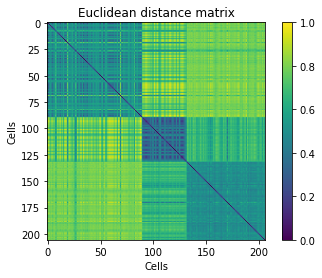

In [14]:
plt.imshow(D_eu[idx][:,idx])
plt.title('Euclidean distance matrix')
plt.xlabel('Cells')
plt.ylabel('Cells')
plt.colorbar()
plt.show()

### Compute OT distance matrix

Now on the OT distance matrix. We first need to normalize cells (divide columns by their sum). This is because Optimal Transport works on probability distributions. We then compute a cost matrix (you may change `cosine` by another function) and the associated OT distance matrix.

In [15]:
# Per-cell normalization (mandatory)
data_norm = adata.X.T.astype(np.double)
data_norm /= data_norm.sum(0)
# Add a small value to avoid numerical errors
data_norm += 1e-9
data_norm /= data_norm.sum(0)

In [16]:
# Compute OT distance matrix
C = otscomics.cost_matrix(adata.X.T.astype(np.double), 'cosine')
D_ot, errors = otscomics.OT_distance_matrix(
    data=data_norm, cost=C, eps=.1,
    dtype=torch.double, device='cpu'
)

Displaying the OT distance matrix, with cells ordered by class. Clusters should be visible in the form of diagonal blocks of low distances.

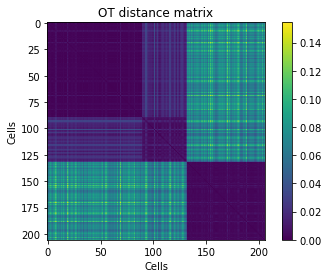

In [17]:
plt.imshow(D_ot[idx][:,idx])
plt.title('OT distance matrix')
plt.xlabel('Cells')
plt.ylabel('Cells')
plt.colorbar()
plt.show()

## Scoring

Let us compare the score for both distance matrices.

### Silhouette score

In [18]:
print('Euclidean\t',  silhouette_score(D_eu, clusters, metric='precomputed'))
print('OT\t\t',       silhouette_score(D_ot, clusters, metric='precomputed'))

Euclidean	 0.3101426773824726
OT		 0.8380411531442389


### C index

In [19]:
print('Euclidean\t',  otscomics.C_index(D_eu, clusters))
print('OT\t\t',       otscomics.C_index(D_ot, clusters))

Euclidean	 0.034578119046118724
OT		 0.0023526581402160966


### Hierarchical clustering (fixed number of clusters)

We first cluster cells based on hierarchical clustering, fixed the number of clusters to the number of classes in the ground truth.

In [20]:
cl = AgglomerativeClustering(affinity='precomputed', n_clusters=len(np.unique(clusters)), linkage='complete')

In [21]:
print('Euclidean')
cl.set_params().fit(D_eu)
print('ARI', adjusted_rand_score(clusters, cl.labels_))
print('NMI', normalized_mutual_info_score(clusters, cl.labels_))
print('AMI', adjusted_mutual_info_score(clusters, cl.labels_))

Euclidean
ARI 0.9215689106896331
NMI 0.9084054726687503
AMI 0.9075477330695365


In [22]:
print('OT')
cl.set_params().fit(D_ot)
print('ARI', adjusted_rand_score(clusters, cl.labels_))
print('NMI', normalized_mutual_info_score(clusters, cl.labels_))
print('AMI', adjusted_mutual_info_score(clusters, cl.labels_))

OT
ARI 1.0
NMI 1.0
AMI 1.0


### Hiarchical clustering (number of clusters derived from silhouette)

A more realistic setting is to find the "optimal" number of clusters in an unsupervised way. We run the clustering for every number of clusters between 3 and 25, and select the clustering yielding the best silhouette score.

In [23]:
cl = AgglomerativeClustering(affinity='precomputed', linkage='complete')

range_clusters, sil = range(3, 26), []

# Iterate through numbers of clusters
for n_clusters in range_clusters:
  cl.set_params(n_clusters=n_clusters).fit(D_eu)
  sil.append(silhouette_score(D_eu, cl.labels_, metric='precomputed'))

# Select the number yielding best silhouette
cl.set_params(n_clusters=range_clusters[np.argmax(sil)]).fit(D_eu)

print('Euclidean,', range_clusters[np.argmax(sil)], 'clusters')
print('ARI', adjusted_rand_score(clusters, cl.labels_))
print('NMI', normalized_mutual_info_score(clusters, cl.labels_))
print('AMI', adjusted_mutual_info_score(clusters, cl.labels_))

Euclidean, 3 clusters
ARI 0.9215689106896331
NMI 0.9084054726687503
AMI 0.9075477330695365


In [24]:
cl = AgglomerativeClustering(affinity='precomputed', linkage='complete')

range_clusters, sil = range(3, 26), []

# Iterate through numbers of clusters
for n_clusters in range_clusters:
  cl.set_params(n_clusters=n_clusters).fit(D_ot)
  sil.append(silhouette_score(D_ot, cl.labels_, metric='precomputed'))

# Select the number yielding best silhouette
cl.set_params(n_clusters=range_clusters[np.argmax(sil)]).fit(D_ot)

print('OT,', range_clusters[np.argmax(sil)], 'clusters')
print('ARI', adjusted_rand_score(clusters, cl.labels_))
print('NMI', normalized_mutual_info_score(clusters, cl.labels_))
print('AMI', adjusted_mutual_info_score(clusters, cl.labels_))

OT, 3 clusters
ARI 1.0
NMI 1.0
AMI 1.0


### A typical single-cell clustering based on Leiden

In practice, single-cell clustering is often done by computing a kNN network according to euclidean distance on PCA components, and then performing Leiden clustering on that network. Here, we compare this typical workflow with Leiden clustering on the kNN network computed directly from the OT distance matrix.

In [25]:
print('PCA + euclidean + kNN + Leiden')

sc.pp.pca(adata)
sc.pp.neighbors(adata)

resolutions = np.linspace(.25, 1.5, 20)
sils, aris, nmis, amis, n_clusters = [], [], [], [], []

# Iterate through resolutions
print('Iterating through resolutions...')
for resolution in tqdm(resolutions):
  
  sc.tl.leiden(adata, resolution=resolution)

  if len(np.unique(adata.obs['leiden'])) > 1:
    sils.append(silhouette_score(D_ot, adata.obs['leiden'], metric='precomputed'))
    aris.append(adjusted_rand_score(clusters, adata.obs['leiden']))
    nmis.append(normalized_mutual_info_score(clusters, adata.obs['leiden']))
    amis.append(adjusted_mutual_info_score(clusters, adata.obs['leiden']))
    n_clusters.append(len(np.unique(adata.obs['leiden'])))
  else:
    sils.append(-1)
    aris.append(-1)
    amis.append(-1)
    nmis.append(-1)
    n_clusters.append(-1)

# Max silhouette score
print('Resolution selected by silhouette score')
i = np.argmax(sils)

print('Resolution', resolutions[i])
print('ARI', aris[i])
print('NMI', nmis[i])
print('AMI', amis[i])
print('nb clusters', n_clusters[i])

PCA + euclidean + kNN + Leiden
Iterating through resolutions...


100%|██████████| 20/20 [00:00<00:00, 46.45it/s]

Resolution selected by silhouette score
Resolution 0.25
ARI 0.921697966842453
NMI 0.8963498310700881
AMI 0.8953788659034694
nb clusters 3


In [26]:
from scanpy.neighbors import _compute_connectivities_umap as conn_umap

In [27]:
print('OT + kNN + Leiden')

# Not used, just creates objects (some useless computations here...)
sc.pp.pca(adata)
sc.pp.neighbors(adata)

knn_indices, knn_dists, forest = sc.neighbors.compute_neighbors_umap(
  D_ot, n_neighbors=15, metric='precomputed')

adata.obsp['distances'], adata.obsp['connectivities'] = conn_umap(
    knn_indices,
    knn_dists,
    adata.shape[0],
    15,
)

resolutions = np.linspace(.25, 1.5, 20)
sils, aris, nmis, amis, n_clusters = [], [], [], [], []

# Iterate through resolutions
print('Iterating through resolutions...')
for resolution in tqdm(resolutions):
  sc.tl.leiden(adata, resolution=resolution)
  if len(np.unique(adata.obs['leiden'])) > 1:
    sils.append(silhouette_score(D_ot, adata.obs['leiden'], metric='precomputed'))
    aris.append(adjusted_rand_score(clusters, adata.obs['leiden']))
    nmis.append(normalized_mutual_info_score(clusters, adata.obs['leiden']))
    amis.append(adjusted_mutual_info_score(clusters, adata.obs['leiden']))
    n_clusters.append(len(np.unique(adata.obs['leiden'])))
  else:
    sils.append(-1)
    aris.append(-1)
    amis.append(-1)
    nmis.append(-1)
    n_clusters.append(-1)

# Max silhouette score
print('Resolution selected by silhouette score')
i = np.argmax(sils)

print('Resolution', resolutions[i])
print('ARI', aris[i])
print('NMI', nmis[i])
print('AMI', amis[i])
print('nb clusters', n_clusters[i])

OT + kNN + Leiden
Iterating through resolutions...


100%|██████████| 20/20 [00:00<00:00, 46.76it/s]

Resolution selected by silhouette score
Resolution 0.25
ARI 1.0
NMI 1.0
AMI 1.0
nb clusters 3
